In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [3]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("1.13.", "2.0.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61406 sha256=2017aeed4e10bf86451d288807c563063f696d90be21b89dd6cb0a58b2c4c358
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31530 sha256=0d4c577890e9e49860cad2fc8d1f24f02865b88938c957192d707beb9def486b
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu118_pyt201/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 90.6 MB/s eta 0:00:00


In [30]:
import torch
from pytorch3d.io import load_obj, save_obj, load_objs_as_meshes
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)

from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    MeshRenderer,
    SoftPhongShader,
    MeshRasterizer,
    TexturesUV,
    TexturesAtlas,
    SoftSilhouetteShader
)
from torchvision.utils import make_grid

import numpy as np

from tqdm.notebook import tqdm

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.rcParams['savefig.dpi']=80
# mpl.rcParams['figure.dpi']=80

if torch.cuda.is_available():
  device=torch.device("cuda:0")
else:
  device=torch.device('cpu')
  print('cannot find gpu')



In [5]:
!pwd

/content


In [6]:
!ls

drive  sample_data


In [7]:
import os
os.chdir('drive/MyDrive/Colab Notebooks')

In [8]:
!ls

 1_b.gif
 2.1.gif
 3_b.gif
'camera_position_optimization(problem).ipynb'
 data
 deform_form.ipynb
 fit_mesh_via_rendering.ipynb
 plot_image_grid.py
 plotly_rendered_meshes.ipynb
 q_5-1_pc1.gif
 q_5-1_pc2.gif
 q_5-1_pc_union.gif
 q_5-2.gif
 q_5-3.gif
 rendering_generic_3d_representations.ipynb
 rendering_parametric_and_implicit.ipynb
 rendering_point_clouds_from_rgbd.ipynb
 rendering_texture_obj.ipynb
 render_tetrahedron_and_retexturing.ipynb
 render_texture_mesh_and_dolly_zoom.ipynb
'sample_pointcloud_from_mesh(problem).ipynb'
 tea_pot.gif


In [9]:
!ls

 1_b.gif
 2.1.gif
 3_b.gif
'camera_position_optimization(problem).ipynb'
 data
 deform_form.ipynb
 fit_mesh_via_rendering.ipynb
 plot_image_grid.py
 plotly_rendered_meshes.ipynb
 q_5-1_pc1.gif
 q_5-1_pc2.gif
 q_5-1_pc_union.gif
 q_5-2.gif
 q_5-3.gif
 rendering_generic_3d_representations.ipynb
 rendering_parametric_and_implicit.ipynb
 rendering_point_clouds_from_rgbd.ipynb
 rendering_texture_obj.ipynb
 render_tetrahedron_and_retexturing.ipynb
 render_texture_mesh_and_dolly_zoom.ipynb
'sample_pointcloud_from_mesh(problem).ipynb'
 tea_pot.gif


In [10]:
!mkdir -p data/cow_mesh
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

--2023-08-10 23:41:03--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.84.160.46, 99.84.160.108, 99.84.160.61, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|99.84.160.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330659 (323K) [text/plain]
Saving to: ‘data/cow_mesh/cow.obj.1’

cow.obj.1           100%[===================>] 322.91K  --.-KB/s    in 0.04s   

2023-08-10 23:41:03 (8.65 MB/s) - ‘data/cow_mesh/cow.obj.1’ saved [330659/330659]

--2023-08-10 23:41:03--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.84.160.46, 99.84.160.108, 99.84.160.61, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|99.84.160.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155 [text/plain]
Saving to: ‘data/cow_mesh/cow.mtl.1’

cow.mtl.1           100%[=

In [22]:


# for case, where input a obj file
DATA_DIR= "./data"
obj_file=os.path.join(DATA_DIR, "cow_mesh/cow.obj")


# verts,faces,aux=load_obj(
#     obj_file,
#     device=device,
#     load_textures=True,
#     create_texture_atlas=True,
#     texture_atlas_size=4,
#     texture_wrap="repeat"
# )



    # so this load_textures=True and create)texture_atlas=Trye, this will be a FloatTensor of this form:
    # (F,texture_size,texture_size,3),then all faces will have a uniform white texture

    # this line works for multiple texture
# mesh=Meshes(verts=[verts], faces=[faces.verts_idx], textures=TexturesAtlas(atlas=[aux.texture_atlas]))


mesh=load_objs_as_meshes([obj_file], device=device)

print(mesh.verts_packed().shape)
print(mesh.faces_packed().shape)



torch.Size([2930, 3])
torch.Size([5856, 3])


In [ ]:
# #only for when using load_objs_as_meshes

# plt.figure(figsize=(5,5))

# texturesuv_image_matplotlib(mesh.textures, subsample=None)
# plt.axis("off");

2. create a renderer and rendering

In [47]:
# the number of different viewpoints from which we want to render the mesh.
num_views = 20

# Get a batch of viewing angles.
elev = torch.linspace(0, 360, num_views)
azim = torch.linspace(-180, 180, num_views)

# Place a point light in front of the object. As mentioned above, the front of
# the cow is facing the -z direction.
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Initialize an OpenGL perspective camera that represents a batch of different
# viewing angles. All the cameras helper methods support mixed type inputs and
# broadcasting. So we can view the camera from the a distance of dist=2.7, and
# then specify elevation and azimuth angles for each viewpoint as tensors.
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)


cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# We arbitrarily choose one particular view that will be used to visualize
# results
camera = FoVPerspectiveCameras(device=device, R=R[None, 1, ...],
                                  T=T[None, 1, ...])

# Define the settings for rasterization and shading. Here we set the output
# image to be of size 128X128. As we are rendering images for visualization
# purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to
# rasterize_meshes.py for explanations of these parameters.  We also leave
# bin_size and max_faces_per_bin to their default values of None, which sets
# their values using heuristics and ensures that the faster coarse-to-fine
# rasterization method is used.  Refer to docs/notes/renderer.md for an
# explanation of the difference between naive and coarse-to-fine rasterization.
raster_settings = RasterizationSettings(
    image_size=128,
    blur_radius=0.0,
    faces_per_pixel=1,
)

# Create a Phong renderer by composing a rasterizer and a shader. The textured
# Phong shader will interpolate the texture uv coordinates for each vertex,
# sample from a texture image and apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=camera,
        lights=lights
    )
)

# Create a batch of meshes by repeating the cow mesh and associated textures.
# Meshes has a useful `extend` method which allows us do this very easily.
# This also extends the textures.
meshes = mesh.extend(num_views)

# Render the cow mesh from each viewing angle
target_images = renderer(meshes, cameras=cameras, lights=lights)

# Our multi-view cow dataset will be represented by these 2 lists of tensors,
# each of length num_views.
target_rgb = [target_images[i, ..., :3] for i in range(num_views)]

target_cameras = [FoVPerspectiveCameras(device=device, R=R[None, i, ...],
                                           T=T[None, i, ...]) for i in range(num_views)]

# print(R[None, 1, ...].shape)  torch.Size([1, 3, 3])
# print(R[1,...].shape)   torch.Size([3, 3])
# print(target_cameras[0].R.shape)   torch.Size([1, 3, 3])

In [27]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2023-08-11 00:04:11--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py.1’

plot_image_grid.py. 100%[===================>]   1.57K  --.-KB/s    in 0.001s  

2023-08-11 00:04:11 (1.55 MB/s) - ‘plot_image_grid.py.1’ saved [1608/1608]



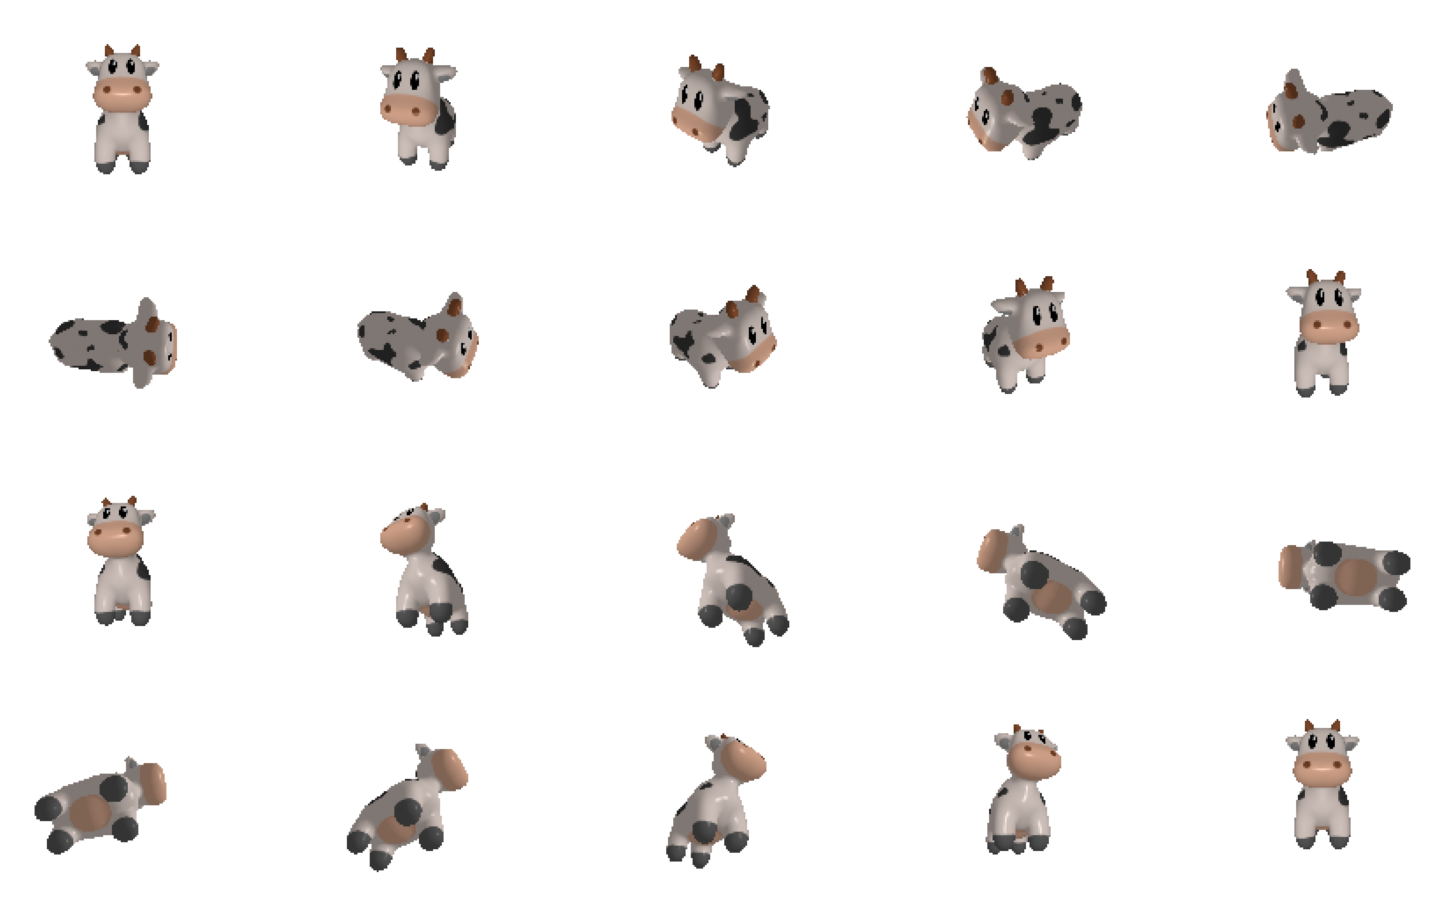

In [28]:
# RGB images
image_grid(target_images.cpu().numpy(), rows=4, cols=5, rgb=True)
plt.show()

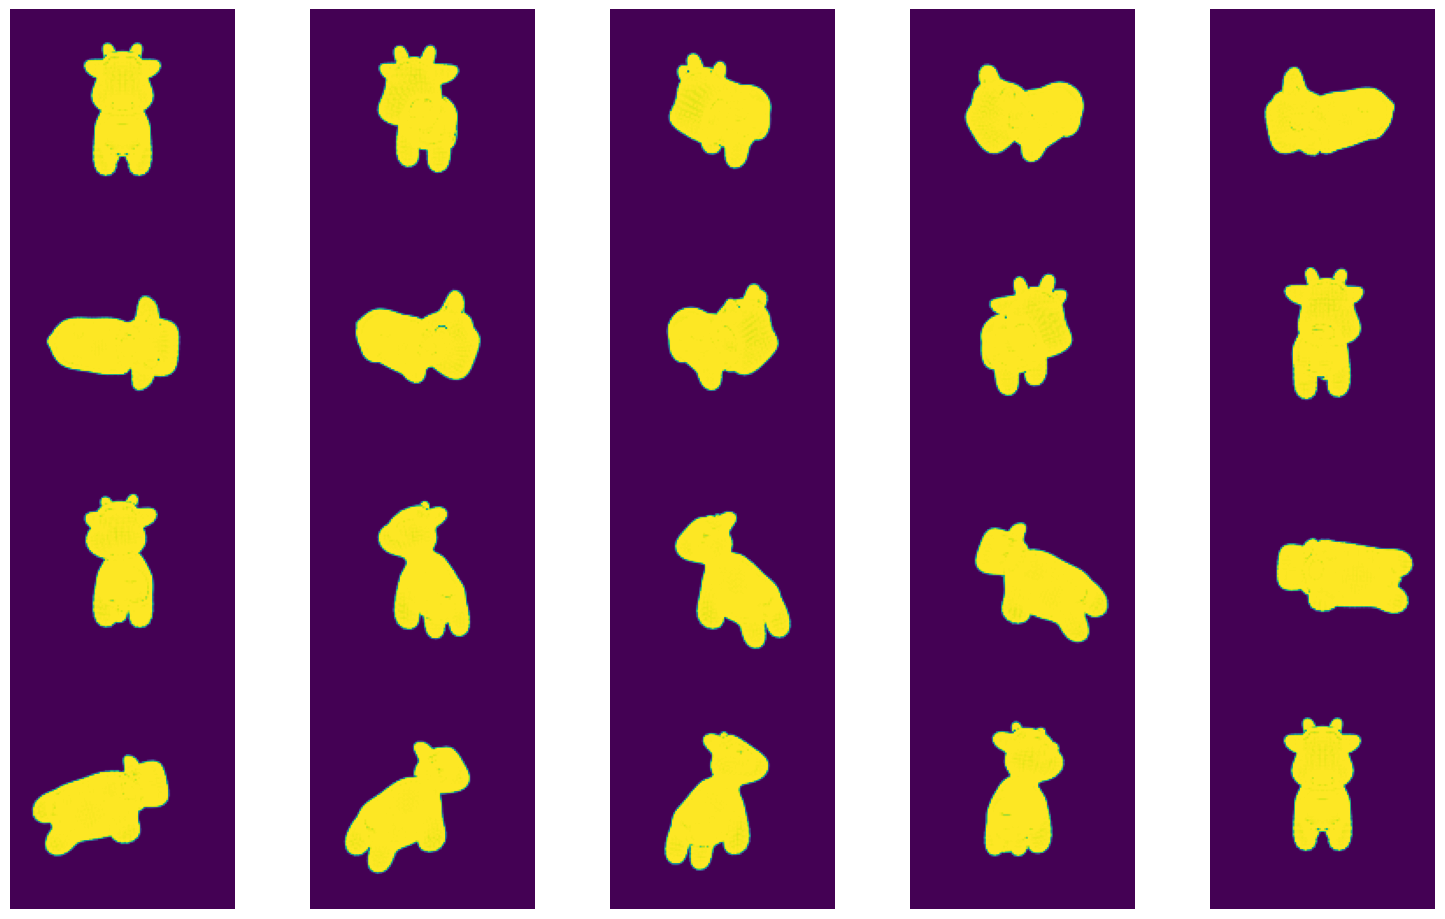

In [32]:
sigma = 1e-4
raster_settings_silhouette = RasterizationSettings(
    image_size=128,
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma,
    faces_per_pixel=50,
)

# Silhouette renderer
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

silhouette_images = renderer_silhouette(meshes, cameras=cameras, lights=lights)
target_silhouette = [silhouette_images[i, ..., 3] for i in range(num_views)]

# Visualize silhouette images
image_grid(silhouette_images.cpu().numpy(), rows=4, cols=5, rgb=False)
plt.show()

  0%|          | 0/2000 [00:00<?, ?it/s]

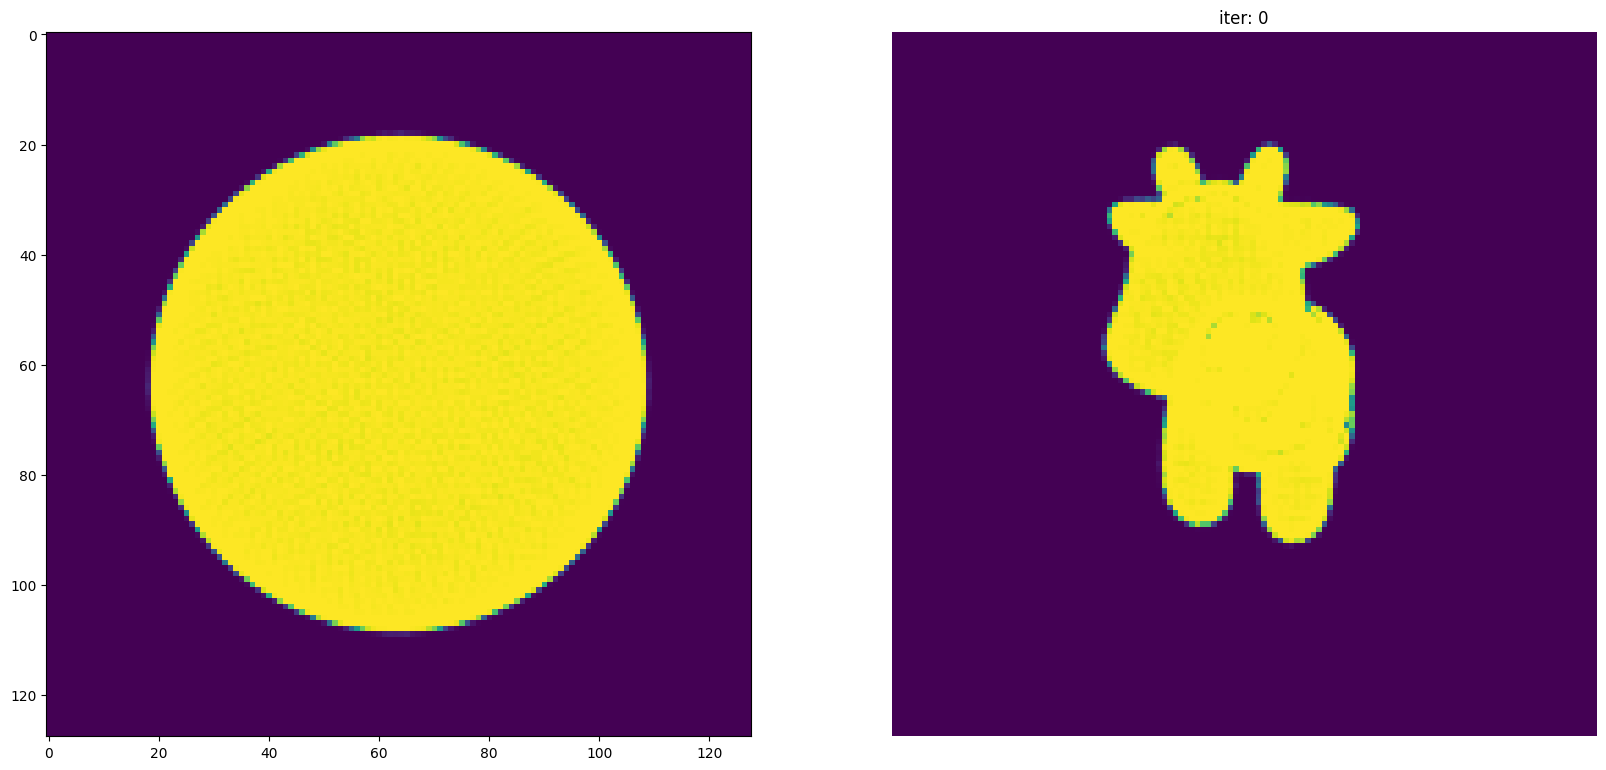

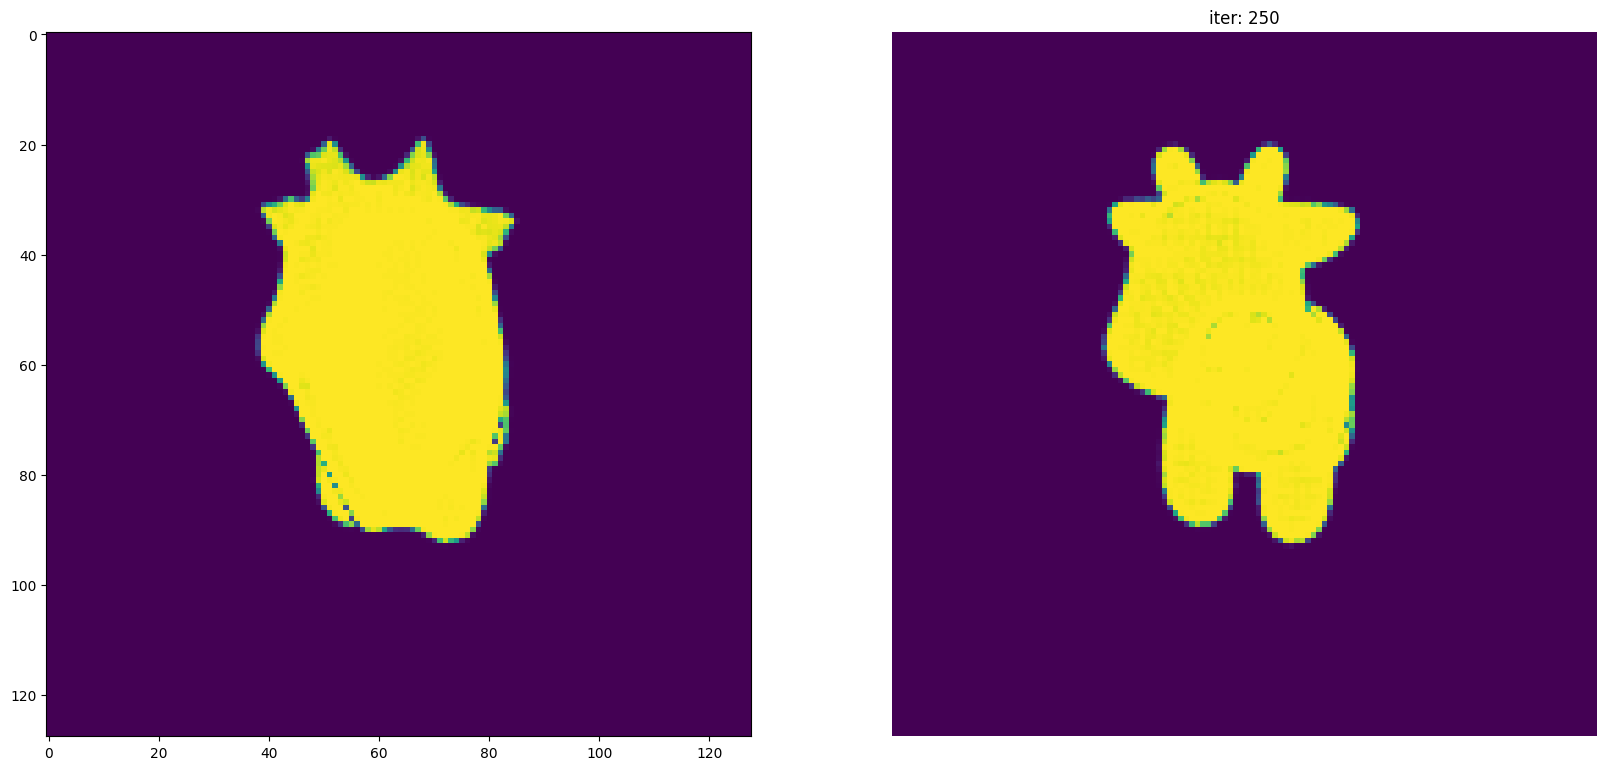

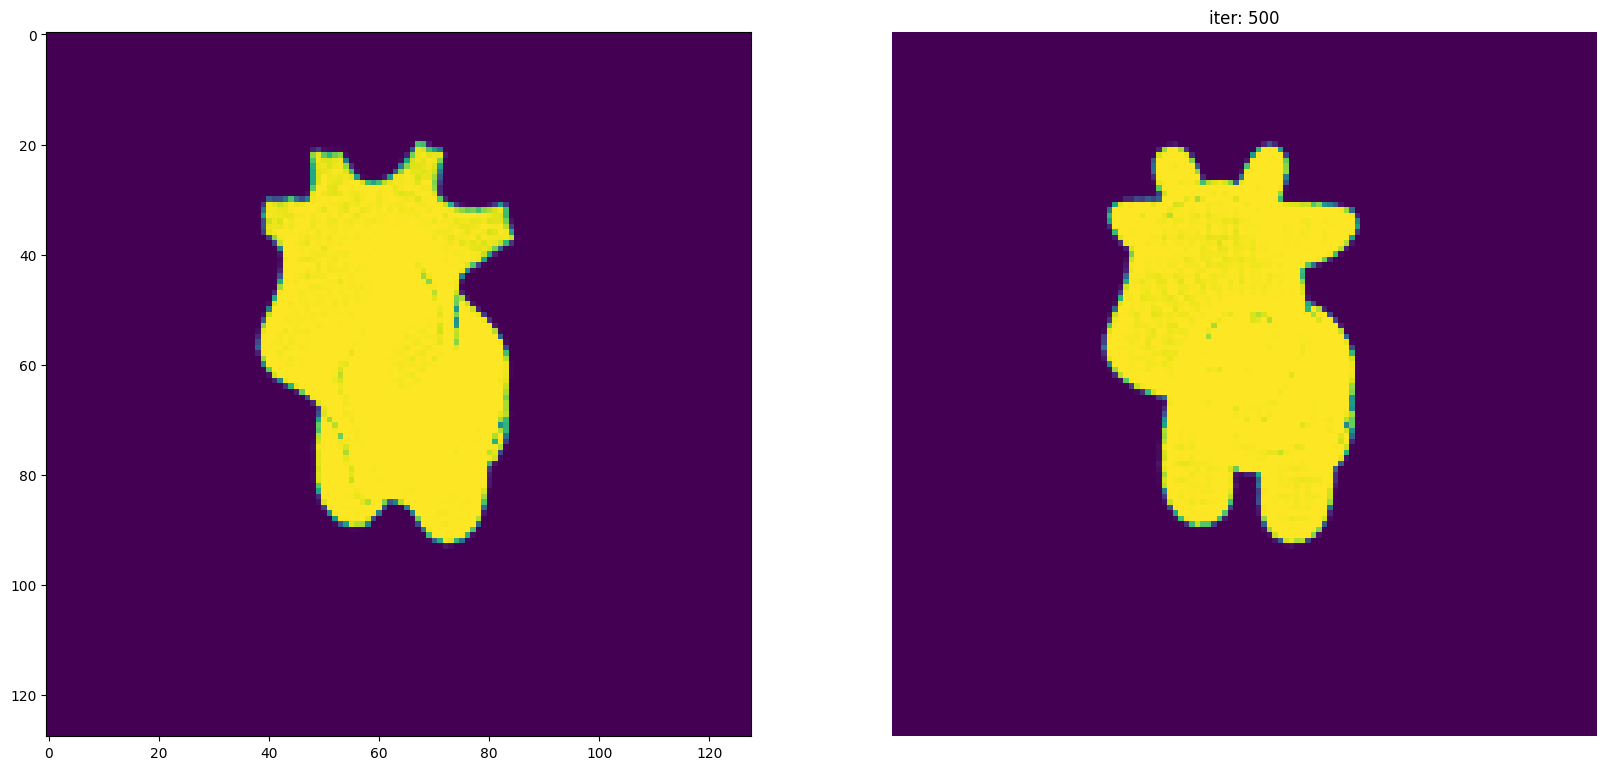

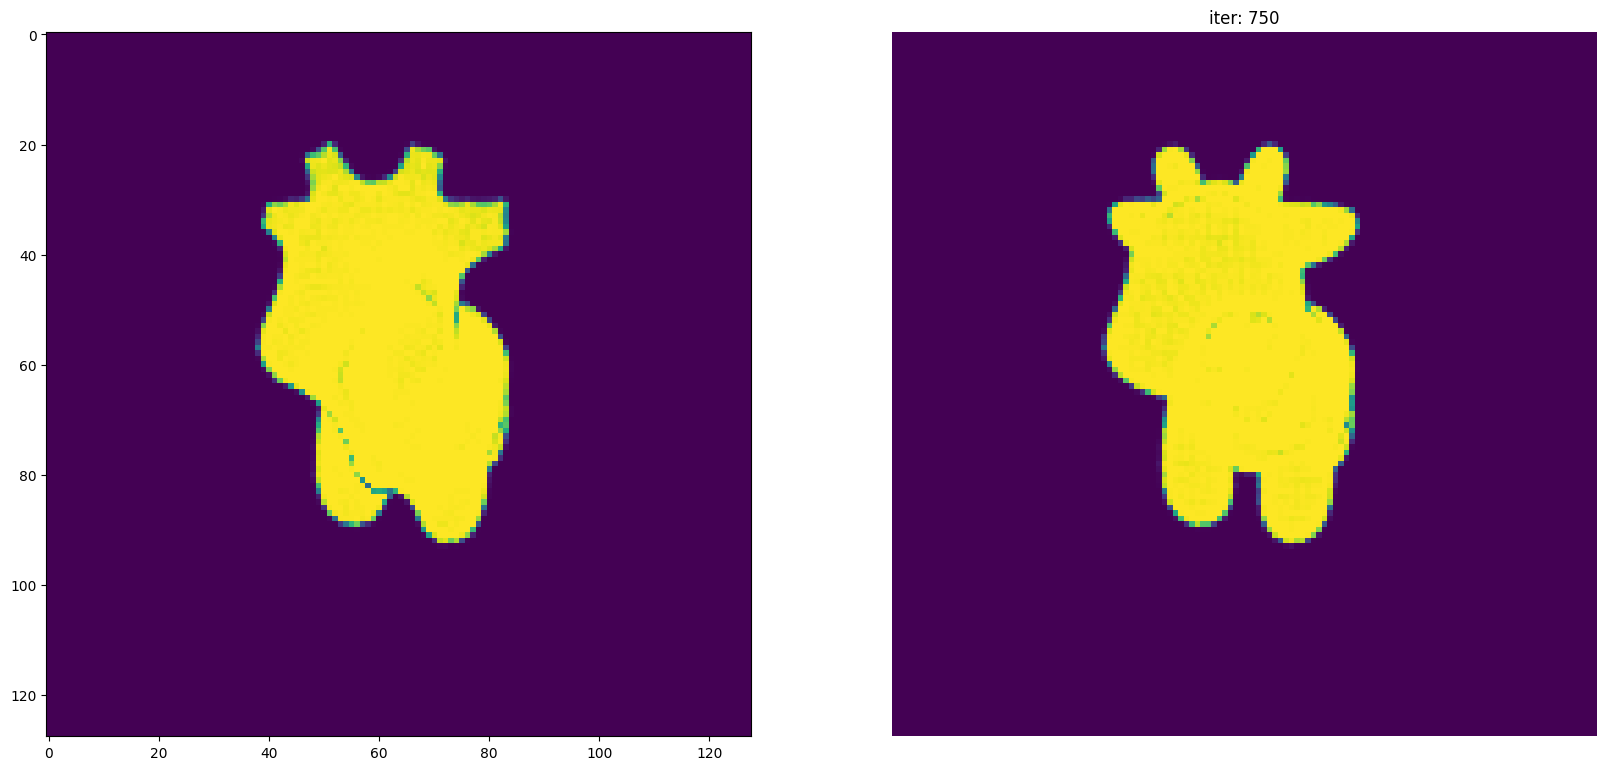

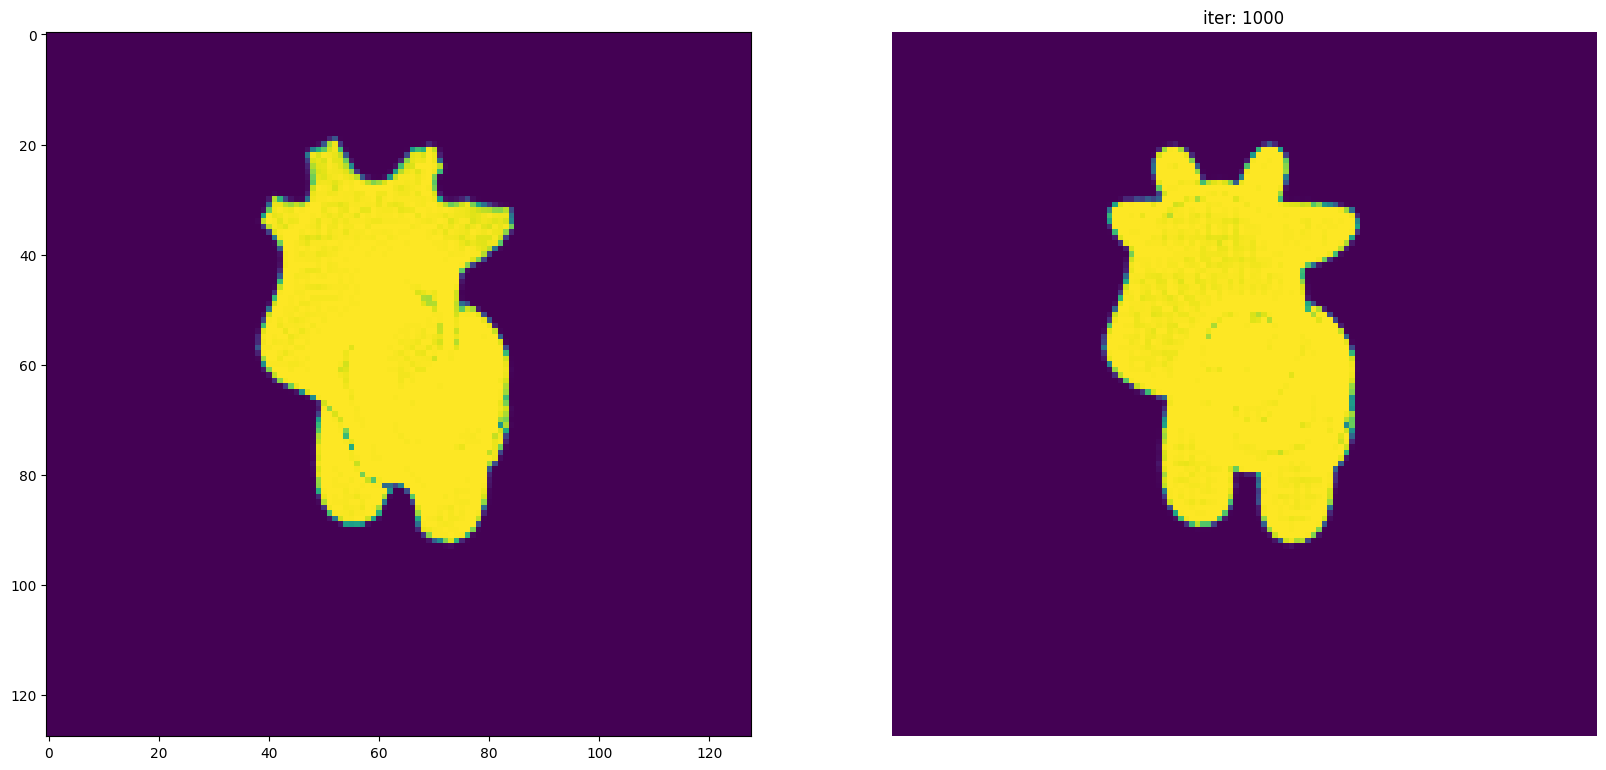

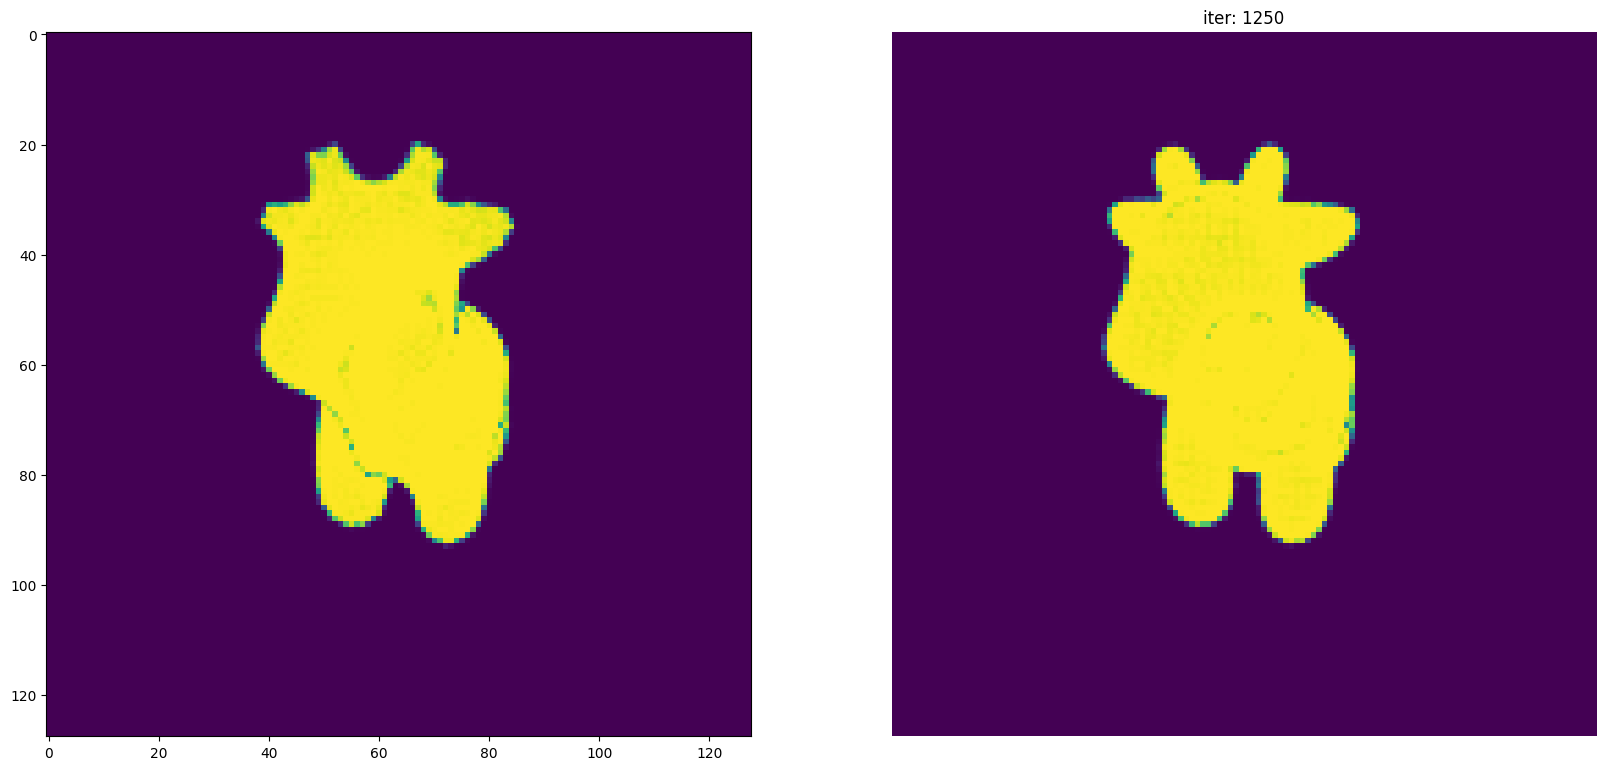

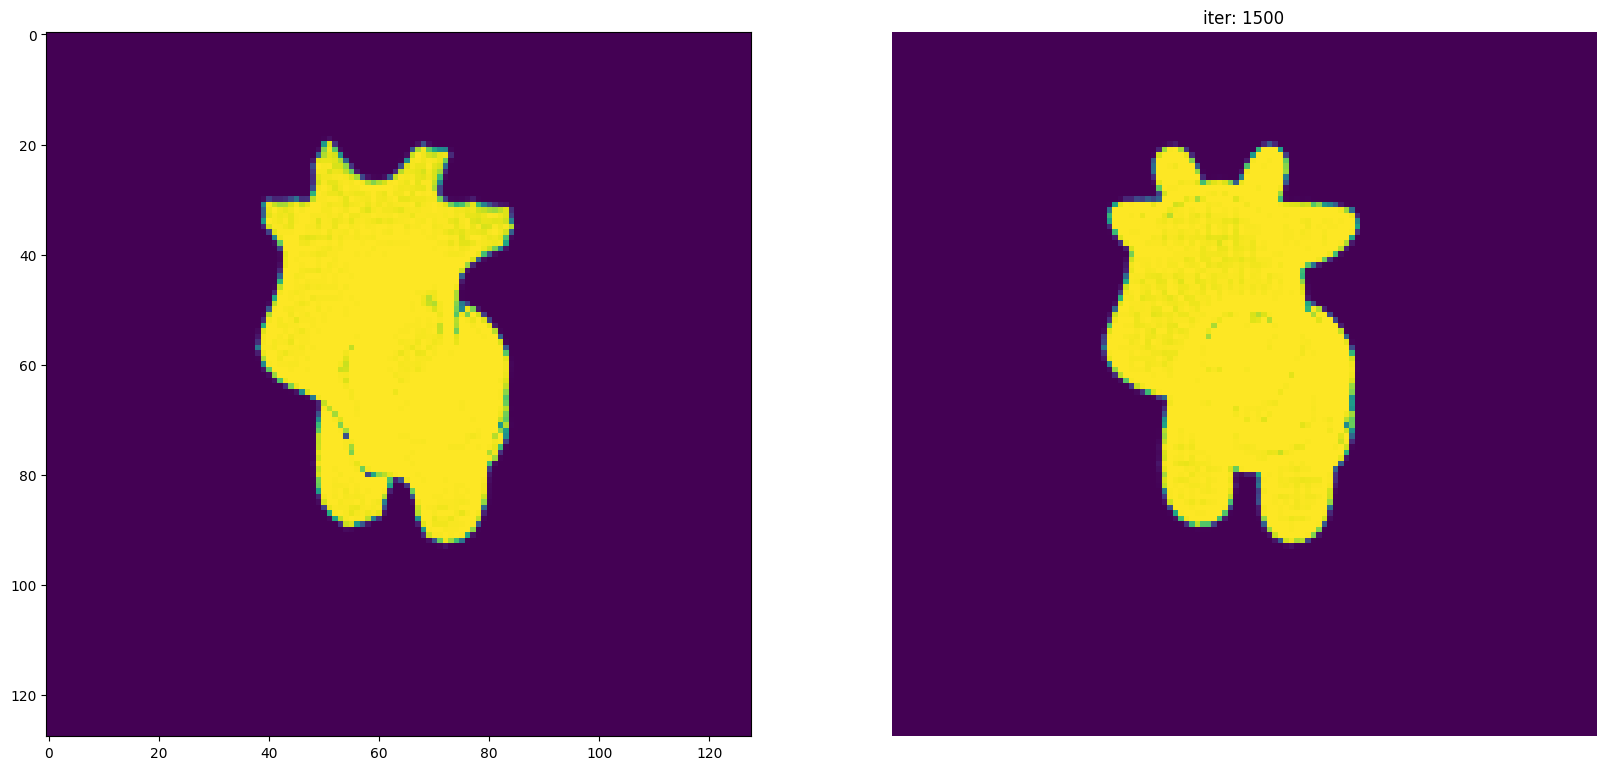

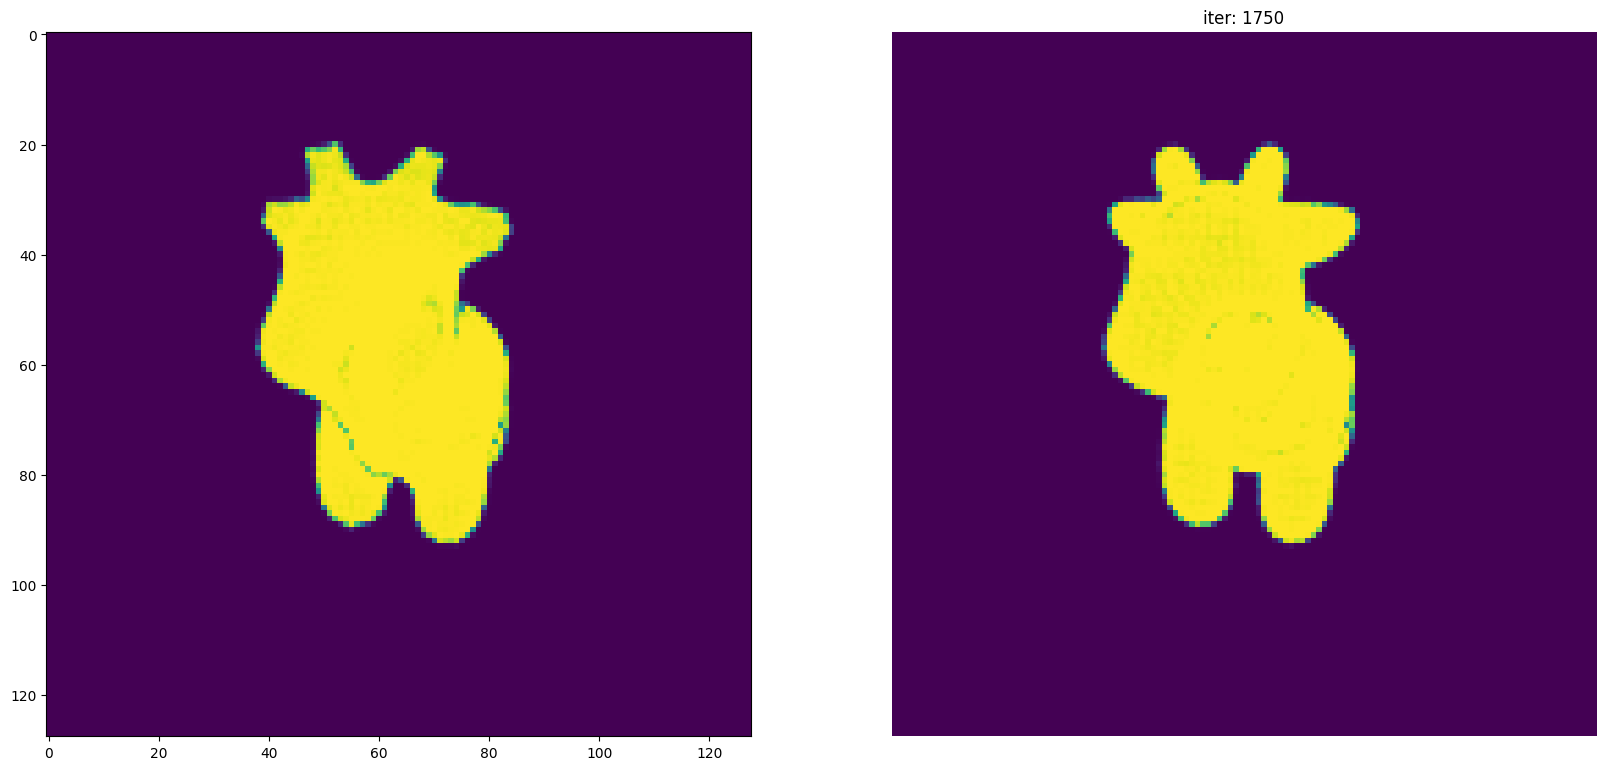

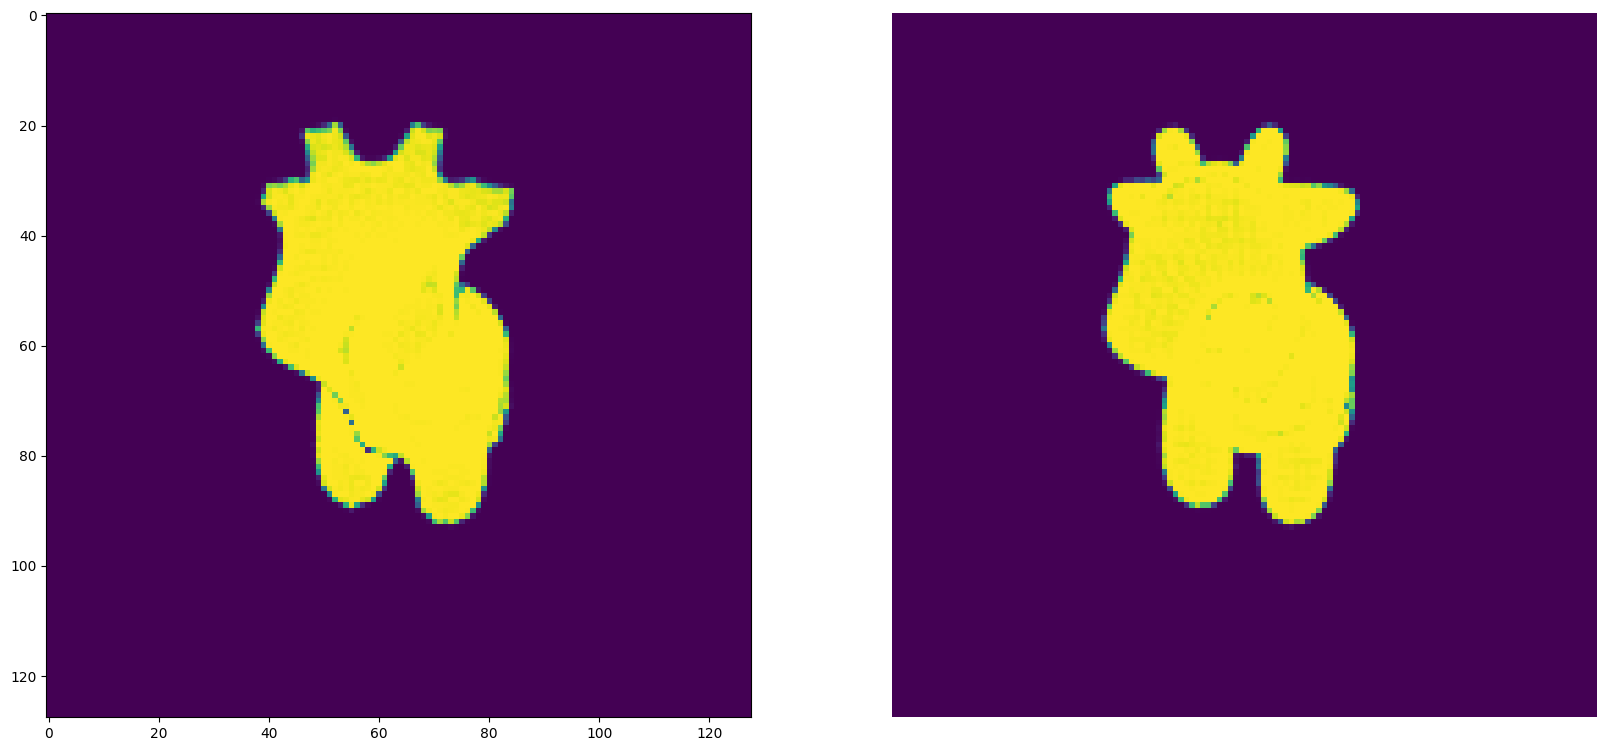

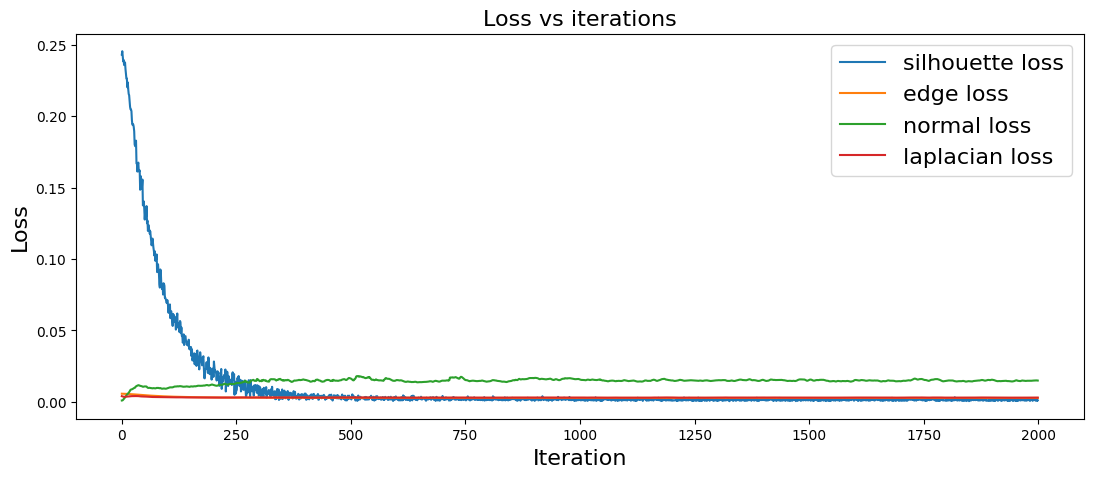

In [36]:
# Show a visualization comparing the rendered predicted mesh to the ground truth
# mesh
def visualize_prediction(predicted_mesh, renderer=renderer_silhouette,
                         target_image=target_rgb[1], title='',
                         silhouette=False):
    inds = 3 if silhouette else range(3)
    with torch.no_grad():
        predicted_images = renderer(predicted_mesh)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())

    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.title(title)
    plt.axis("off")

# Plot losses as a function of optimization iteration
def plot_losses(losses):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for k, l in losses.items():
        ax.plot(l['values'], label=k + " loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16")

# We initialize the source shape to be a sphere of radius 1.
src_mesh = ico_sphere(4, device)

# Rasterization settings for differentiable rendering, where the blur_radius
# initialization is based on Liu et al, 'Soft Rasterizer: A Differentiable
# Renderer for Image-based 3D Reasoning', ICCV 2019
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=128,
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma,
    faces_per_pixel=50,
)

# Silhouette renderer
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings_soft
    ),
    shader=SoftSilhouetteShader()
)


# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 2
# Number of optimization steps
Niter = 2000
# Plot period for the losses
plot_period = 250

%matplotlib inline

# Optimize using rendered silhouette image loss, mesh edge loss, mesh normal
# consistency, and mesh laplacian smoothing
losses = {"silhouette": {"weight": 1.0, "values": []},
          "edge": {"weight": 1.0, "values": []},
          "normal": {"weight": 0.01, "values": []},
          "laplacian": {"weight": 1.0, "values": []},
         }

# Losses to smooth / regularize the mesh shape
def update_mesh_shape_prior_losses(mesh, loss):
    # and (b) the edge length of the predicted mesh
    loss["edge"] = mesh_edge_loss(mesh)

    # mesh normal consistency
    loss["normal"] = mesh_normal_consistency(mesh)

    # mesh laplacian smoothing
    loss["laplacian"] = mesh_laplacian_smoothing(mesh, method="uniform")

# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in
# src_mesh
verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)


loop = tqdm(range(Niter))

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()

    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)

    # Losses to smooth /regularize the mesh shape
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    update_mesh_shape_prior_losses(new_src_mesh, loss)

    # Compute the average silhouette loss over two random views, as the average
    # squared L2 distance between the predicted silhouette and the target
    # silhouette from our dataset
    for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
        images_predicted = renderer_silhouette(new_src_mesh, cameras=target_cameras[j], lights=lights)
        predicted_silhouette = images_predicted[..., 3]
        loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
        loss["silhouette"] += loss_silhouette / num_views_per_iteration

    # Weighted sum of the losses
    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(float(l.detach().cpu()))


    # Print the losses
    loop.set_description("total_loss = %.6f" % sum_loss)

    # Plot mesh
    if i % plot_period == 0:
        visualize_prediction(new_src_mesh, title="iter: %d" % i, silhouette=True,
                             target_image=target_silhouette[1])

    # Optimization step
    sum_loss.backward()
    optimizer.step()


visualize_prediction(new_src_mesh, silhouette=True,
                     target_image=target_silhouette[1])
plot_losses(losses)